**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.special import iv
from scipy.optimize import minimize


**CIR Simulation Function**

In [2]:
def simulate_CIR(k, theta, sigma, r0, T, N):
    dt = T / N
    r = np.zeros(N + 1)
    r[0] = r0
    for t in range(1, N + 1):
        Z = np.random.randn()
        r[t] = r[t-1] + k*(theta - r[t-1])*dt + sigma*np.sqrt(dt)*np.sqrt(max(r[t-1], 0))*Z
    return r


**OLS Estimation for CIR**

In [3]:
def CIR_OLS(data, dt):
    rs = data[:-1]
    rt = data[1:]

    X1 = dt / np.sqrt(rs)
    X2 = dt * np.sqrt(rs)
    y = (rt - rs) / np.sqrt(rs)

    X = np.column_stack((X1, X2))
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    beta1, beta2 = model.coef_
    k = -beta2
    theta = beta1 / k
    sigma = np.std(y - model.predict(X)) / np.sqrt(dt)

    return k, theta, sigma


** CIR Log-Likelihood Function**



In [4]:
def CIR_log_likelihood(data, dt, k, theta, sigma):
    rs = data[:-1]
    rt = data[1:]

    c = (2 * k) / (sigma**2 * (1 - np.exp(-k*dt)))
    u = c * np.exp(-k*dt) * rs
    v = c * rt
    q = (2 * k * theta / sigma**2) - 1
    z = 2 * np.sqrt(u * v)
    return len(rs) * np.log(c) + np.sum(-u - v + 0.5*q*np.log(v/u) + np.log(iv(q, z)))



**Negative Log-Likelihood (for MLE)**

In [5]:
def neg_log_likelihood(params):
    k, theta, sigma = params
    return -CIR_log_likelihood(data, dt, k, theta, sigma)


**Simulation and Estimation**

In [6]:
# Set true parameters
k_true = 7
theta_true = 0.05
sigma_true = 0.5
r0 = 0.3
T, N = 1, 100
dt = T / N

# Simulate data
np.random.seed(123)
data = simulate_CIR(k_true, theta_true, sigma_true, r0, T, N)

# OLS Estimation
k_ols, theta_ols, sigma_ols = CIR_OLS(data, dt)

# MLE Estimation
result = minimize(neg_log_likelihood, [k_ols, theta_ols, sigma_ols], method='Nelder-Mead')
k_mle, theta_mle, sigma_mle = result.x

# Output results
print(f"True Parameters:     k={k_true:.4f}, theta={theta_true:.4f}, sigma={sigma_true:.4f}")
print(f"OLS Estimated:       k={k_ols:.4f}, theta={theta_ols:.4f}, sigma={sigma_ols:.4f}")
print(f"MLE Estimated:       k={k_mle:.4f}, theta={theta_mle:.4f}, sigma={sigma_mle:.4f}")


True Parameters:     k=7.0000, theta=0.0500, sigma=0.5000
OLS Estimated:       k=8.9652, theta=0.0574, sigma=0.5624
MLE Estimated:       k=9.7810, theta=0.0585, sigma=0.5982


**Plot Simulated CIR Path**

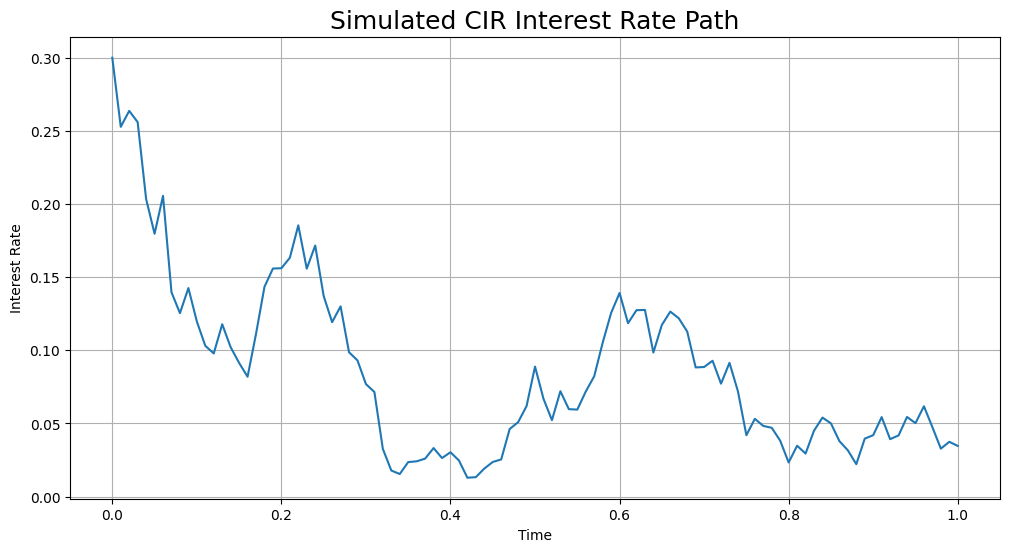

In [7]:
# Plot the simulated CIR path
time = np.linspace(0, T, N+1)
plt.figure(figsize=(12,6))
sns.lineplot(x=time, y=data)
plt.title("Simulated CIR Interest Rate Path", fontsize=18)
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.show()


**3D Log-Likelihood Plot Function (Fixing One Param)**

In [9]:
def plot_log_likelihood_fixed_param(fixed, value, x_range, y_range, param_names):
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            params = [0, 0, 0]
            idx = ['k', 'theta', 'sigma']
            for name, val in zip(idx, [X[i,j], Y[i,j], value]):
                if name == fixed:
                    val = value
                params[idx.index(name)] = val
            Z[i,j] = CIR_log_likelihood(data, dt, *params)

    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel(param_names[0])
    ax.set_ylabel(param_names[1])
    ax.set_zlabel('Log-Likelihood')
    ax.set_title(f"Log-Likelihood with fixed {fixed.capitalize()}", fontsize=16)
    plt.show()


**Call the 3D Plot Function**

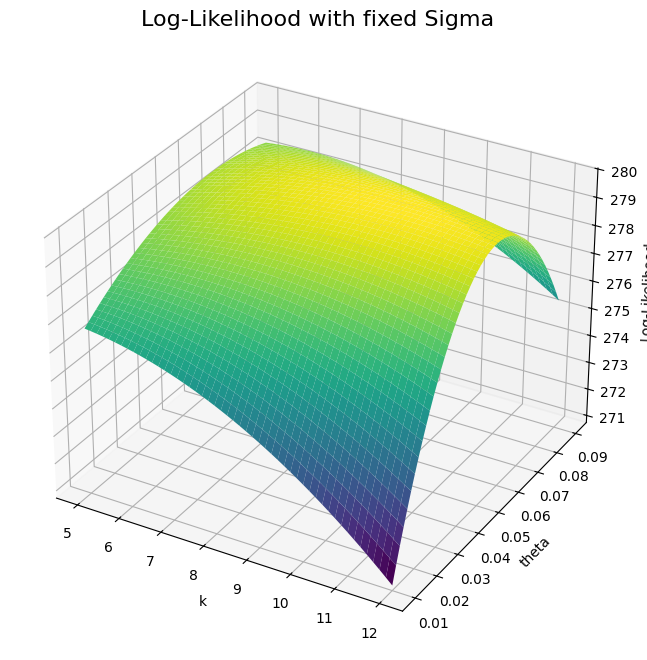

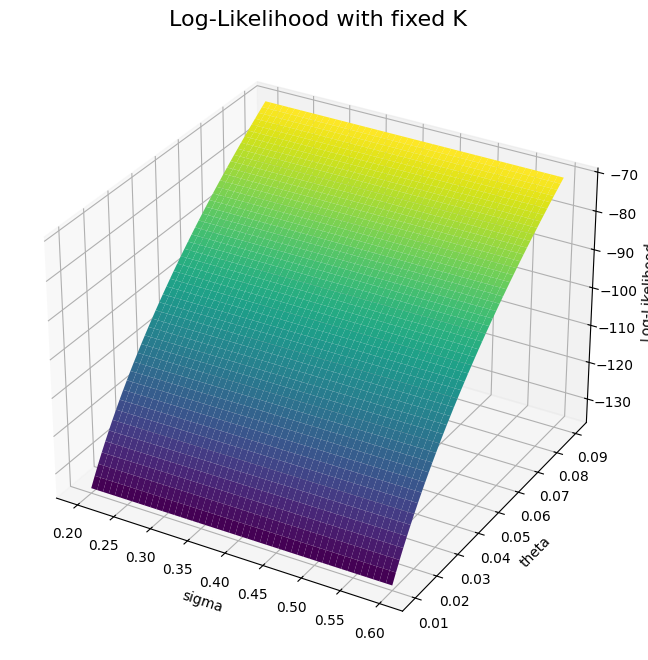

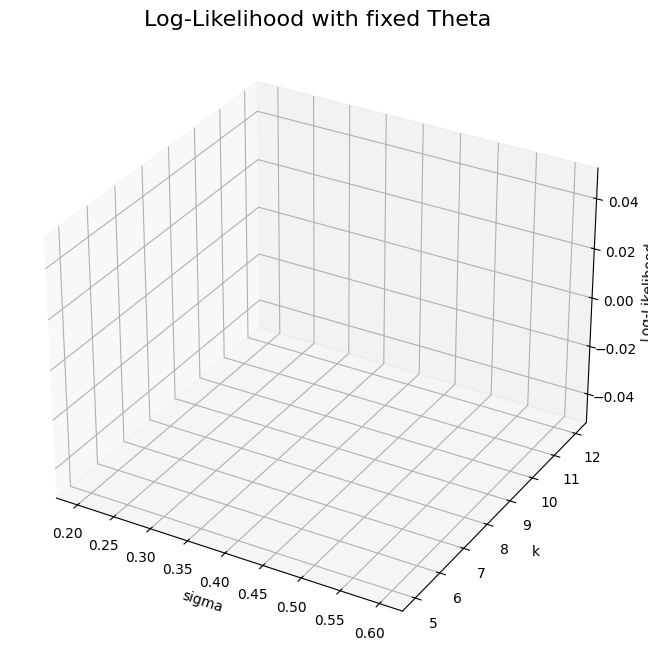

In [10]:
plot_log_likelihood_fixed_param('sigma', sigma_mle, np.linspace(5, 12, 50), np.linspace(0.01, 0.09, 50), ['k', 'theta'])
plot_log_likelihood_fixed_param('k', k_mle, np.linspace(0.2, 0.6, 50), np.linspace(0.01, 0.09, 50), ['sigma', 'theta'])
plot_log_likelihood_fixed_param('theta', theta_mle, np.linspace(0.2, 0.6, 50), np.linspace(5, 12, 50), ['sigma', 'k'])


**2D Log-Likelihood Curve Plots**

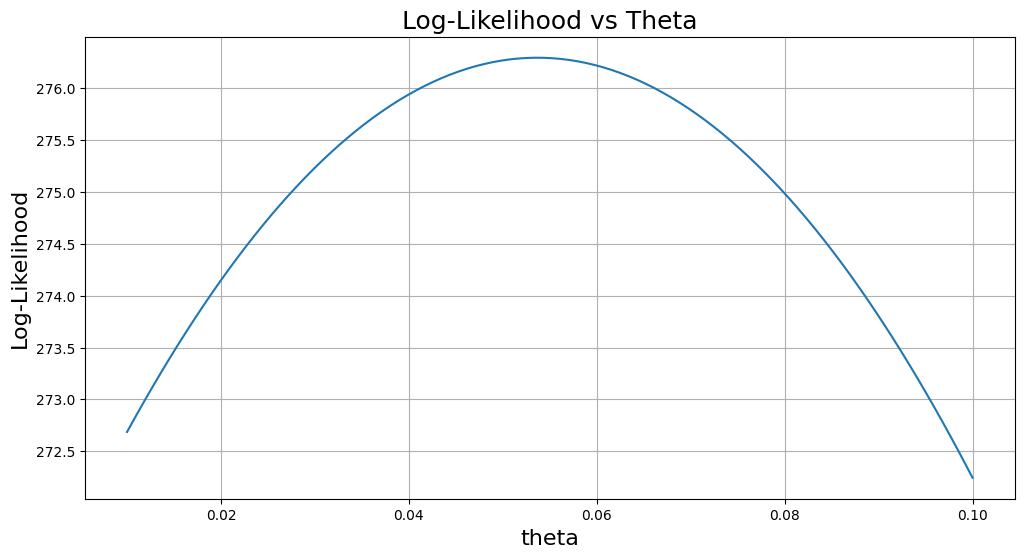

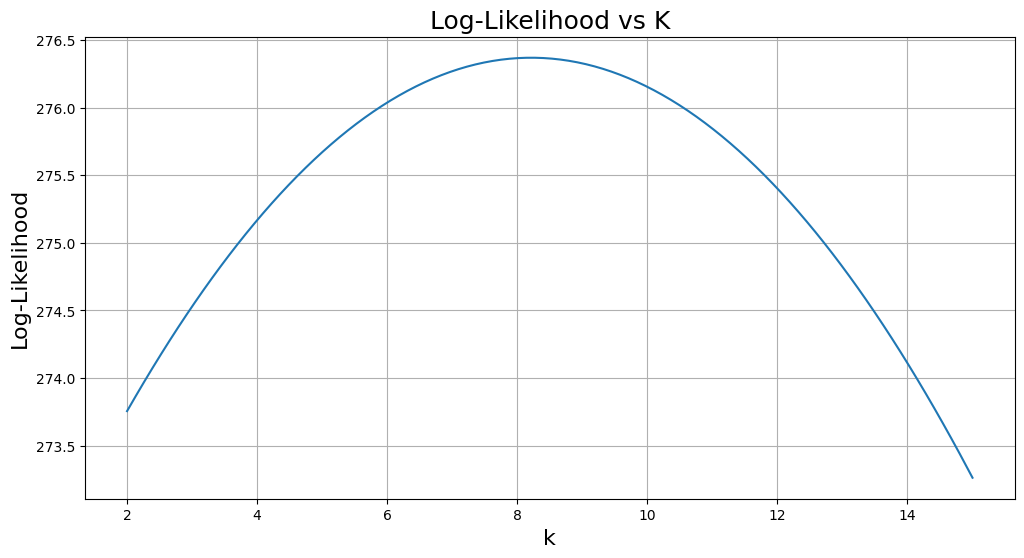

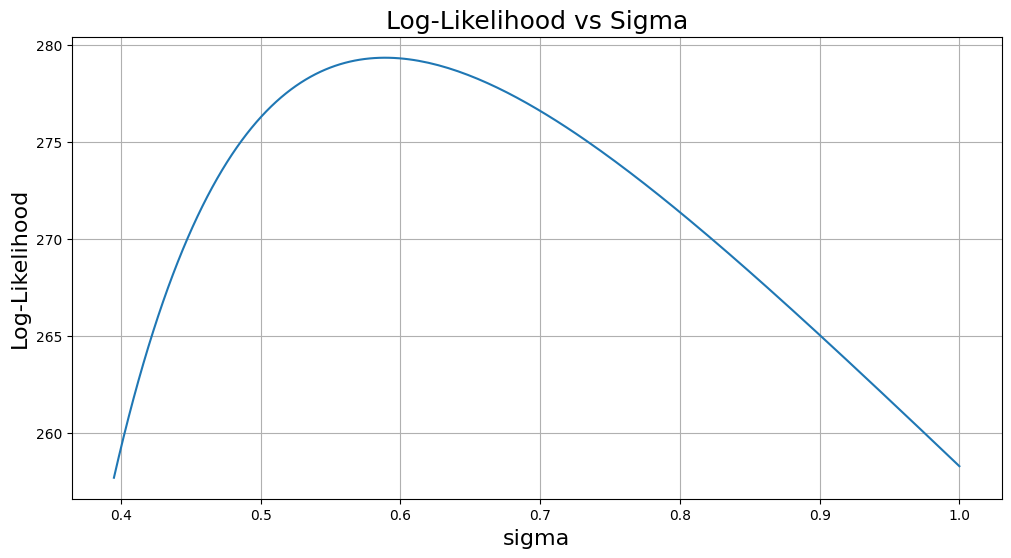

In [11]:
def plot_2d_likelihood(param_name, fixed_values, param_range):
    likelihood = []

    for val in param_range:
        params = fixed_values.copy()
        idx = ['k', 'theta', 'sigma'].index(param_name)
        params[idx] = val
        likelihood.append(CIR_log_likelihood(data, dt, *params))

    plt.figure(figsize=(12,6))
    plt.plot(param_range, likelihood)
    plt.xlabel(param_name, fontsize=16)
    plt.ylabel('Log-Likelihood', fontsize=16)
    plt.title(f'Log-Likelihood vs {param_name.capitalize()}', fontsize=18)
    plt.grid(True)
    plt.show()

plot_2d_likelihood('theta', [k_true, 0.05, sigma_true], np.linspace(0.01, 0.1, 200))
plot_2d_likelihood('k', [7, theta_true, sigma_true], np.linspace(2, 15, 200))
plot_2d_likelihood('sigma', [k_true, theta_true, 0.5], np.linspace(0.3, 1.0, 200))
